# Skapa 2 modeller per ticker   
1. En modell som använder tomorrows close som target  
2. En modell som använder day after tomorrows close som target   

In [2]:
import sklearn
import xgboost as xgb
from pytrends.request import TrendReq
import pytrends
import pandas as pd
from datetime import datetime as dt
import yfinance as yf
import ta
import matplotlib.pyplot as plt 
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score    
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
# plt.style.use('fivethirtyeight')
pd.set_option('display.width', 200)
import plotly.express as px
import streamlit as st
import google

In [3]:
# print pandas version
print('pandas=={}'.format(pd.__version__))
# print matplotlib version
print('matplotlib=={}'.format(plt.matplotlib.__version__))
# print yfinance version
print('yfinance=={}'.format(yf.__version__))
# print pytreands version
print('pytrends==4.8.0') 
# print python-dateutil version
print('python-dateutil==2.8.2')
# print ta version
print('ta==0.10.2')
# print streamlit version
print('streamlit=={}'.format(st.__version__))
print('xgboost=={}'.format(xgb.__version__))
print('sklearn=={}'.format(sklearn.__version__))
#print google version
print('google-crc32==1.1.2')
# print pandas-ta version
print('pandas-ta==0.3.14b0')
# print plotly version
print('plotly==5.3.1')


pandas==1.4.3
matplotlib==3.5.2
yfinance==0.1.72
pytrends==4.8.0
python-dateutil==2.8.2
ta==0.10.2
streamlit==1.13.0
xgboost==1.6.1
sklearn==1.1.1
google-crc32==1.1.2
pandas-ta==0.3.14b0
plotly==5.3.1


In [4]:
tickers = ['BTC-USD','ETH-USD','BCH-USD','ZRX-USD','XRP-USD']
ticker_names = ['Bitcoin','Ethereum','Bitcoin Cash','0X','Ripple']

In [5]:
# fill up a dataframe with all dates from 2015 up to today
def get_all_dates():
    start_date = dt(2005, 1, 1)
    end_date = dt.today()
    dates = pd.date_range(start_date, end_date)
    df = pd.DataFrame(index=dates)
    return df


## get Google Trends Crypto data


Bitcoin
Ethereum
Bitcoin Cash
0X
Ripple


,Bitcoin,Ethereum,Bitcoin Cash,0X,Ripple,Bitcoin_30,Ethereum_30,Bitcoin Cash_30,0X_30,Ripple_30,Bitcoin_90,Ethereum_90,Bitcoin Cash_90,0X_90,Ripple_90,Bitcoin_250,Ethereum_250,Bitcoin Cash_250,0X_250,Ripple_250
2022-10-05,0.733333,0.733333,0.1,0.0,0.1,0.872222,0.983333,0.127778,0.083333,0.1,0.991111,1.095556,0.140370,0.137778,0.1,1.168933,1.221333,0.165867,0.289467,0.124667
2022-10-06,0.733333,0.733333,0.1,0.0,0.1,0.866667,0.973333,0.126667,0.080000,0.1,0.985556,1.090370,0.139630,0.136296,0.1,1.165867,1.217467,0.165333,0.288533,0.124400
2022-10-07,0.733333,0.733333,0.1,0.0,0.1,0.861111,0.963333,0.125556,0.076667,0.1,0.980000,1.085185,0.138889,0.134815,0.1,1.162800,1.213600,0.164800,0.287600,0.124133
2022-10-08,0.733333,0.733333,0.1,0.0,0.1,0.855556,0.953333,0.124444,0.073333,0.1,0.974444,1.080000,0.138148,0.133333,0.1,1.159733,1.209733,0.164267,0.286667,0.123867
2022-10-09,0.733333,0.733333,0.1,0.0,0.1,0.850000,0.943333,0.123333,0.070000,0.1,0.968889,1.074815,0.137407,0.131852,0.1,1.157467,1.206267,0.163867,0.285333,0.123600


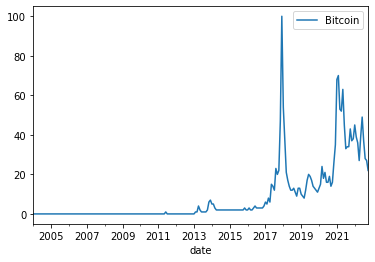

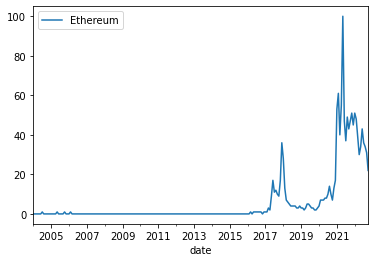

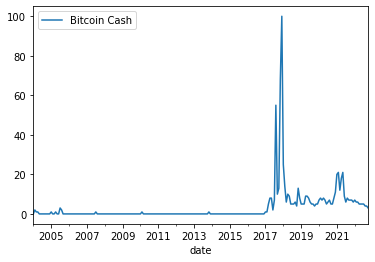

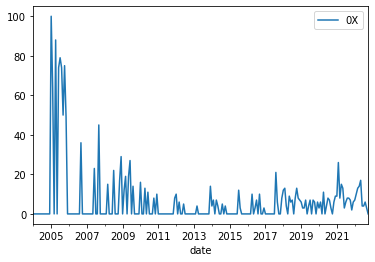

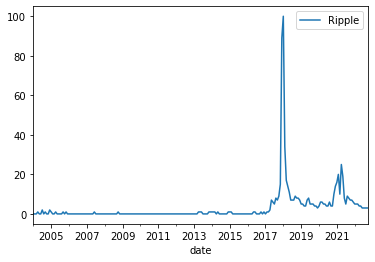

In [6]:
# get google trends data
from pytrends.request import TrendReq

pytrends = TrendReq()
df_trend = get_all_dates()
for ticker_name in ticker_names:
    print(ticker_name)
    pytrends.build_payload(kw_list=[ticker_name], cat=7, timeframe='all')
    df_temp = pytrends.interest_over_time()
    df_temp = df_temp.drop(columns=['isPartial'])
    df_temp.plot()
    df_trend = df_trend.merge(df_temp, how='left', left_index=True, right_index=True)
    df_trend[ticker_name] = df_trend[ticker_name].fillna(method='ffill')/30
    df_trend[ticker_name+'_30'] = df_trend[ticker_name].rolling(30, 1).mean()
    df_trend[ticker_name+'_90'] = df_trend[ticker_name].rolling(90, 1).mean()
    df_trend[ticker_name+'_250'] = df_trend[ticker_name].rolling(250, 1).mean()
    
    
# gruppera kolumnerna per typ av data
df_trend = df_trend[ticker_names + [ticker_name+'_30' for ticker_name in ticker_names] + [ticker_name+'_90' for ticker_name in ticker_names] + [ticker_name+'_250' for ticker_name in ticker_names]]

df_trend.tail()


In [7]:
df_trend.to_csv('google_trends.csv')


## skapa alla modellerna

In [8]:
df_trend.query('index>"2017-01-01"').sample(6)


,Bitcoin,Ethereum,Bitcoin Cash,0X,Ripple,Bitcoin_30,Ethereum_30,Bitcoin Cash_30,0X_30,Ripple_30,Bitcoin_90,Ethereum_90,Bitcoin Cash_90,0X_90,Ripple_90,Bitcoin_250,Ethereum_250,Bitcoin Cash_250,0X_250,Ripple_250
2022-03-29,1.200000,1.300000,0.200000,0.433333,0.166667,1.203333,1.310000,0.200000,0.430000,0.166667,1.335926,1.535556,0.211481,0.328148,0.167407,1.269733,1.544000,0.224533,0.250533,0.215600
2020-04-19,0.600000,0.233333,0.266667,0.366667,0.166667,0.673333,0.233333,0.254444,0.232222,0.178889,0.616296,0.221111,0.251111,0.154074,0.184815,0.500533,0.138133,0.198267,0.141067,0.154133
2021-04-13,1.733333,1.833333,0.600000,0.500000,0.833333,1.752222,1.550000,0.486667,0.367778,0.550000,2.038148,1.710000,0.575556,0.493704,0.549259,1.285733,0.945333,0.383333,0.289867,0.375867
2018-01-12,1.800000,0.933333,0.833333,0.400000,3.333333,2.720000,1.093333,2.333333,0.320000,3.113333,2.048889,0.783333,2.096667,0.145185,1.689630,1.107333,0.530667,1.108933,0.163067,0.753200
2017-07-13,0.400000,0.366667,0.233333,0.000000,0.166667,0.437778,0.480000,0.138889,0.000000,0.185556,0.421111,0.357037,0.195185,0.000000,0.182963,0.265867,0.156667,0.113733,0.012400,0.081600
2022-01-26,1.500000,1.700000,0.233333,0.233333,0.166667,1.468889,1.673333,0.228889,0.228889,0.171111,1.328519,1.626667,0.221852,0.166296,0.202593,1.315733,1.609867,0.255867,0.205200,0.246267


In [9]:
def get_all(tickers):
    df = pd.DataFrame()
    for ticker in tickers:
        all_tickers = yf.download(ticker)
        df[ticker] = yf.download(ticker, period='max')['Close']
        
    df.index = pd.to_datetime(df.index)
    return df

In [10]:
df_org= get_all(tickers)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [11]:
display(df_org.isna().sum())
display(df_org.head())
df_org.shape

BTC-USD       0
ETH-USD    1149
BCH-USD    1149
ZRX-USD    1081
XRP-USD    1149
dtype: int64

,BTC-USD,ETH-USD,BCH-USD,ZRX-USD,XRP-USD
Date,,,,,
2014-09-17,457.334015,NaN,NaN,NaN,NaN
2014-09-18,424.440002,NaN,NaN,NaN,NaN
2014-09-19,394.795990,NaN,NaN,NaN,NaN
2014-09-20,408.903992,NaN,NaN,NaN,NaN
2014-09-21,398.821014,NaN,NaN,NaN,NaN


(2945, 5)

In [12]:

def fit_predict(train, test, target, predictors, model, proba_val=None):
    model.fit(train[predictors], train[target])

    if proba_val:  # använd proba
        preds = model.predict_proba(test[predictors])[:, 1]
        preds[preds >= proba_val] = 1
        preds[preds < proba_val] = 0
    else:    # använd predict utan proba
        preds = model.predict(test[predictors])

    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test[target], preds], axis=1)

    return combined



Backtest av modellerna

In [13]:
def backtest(data, target, model, predictors, gap=0, proba_val=0.6, start=360, step=180):
    """"
    Args:
        data (DataFrame): Data to use for backtesting
        taregt (str): Name of the target column
        model: Tex RandomForestClassifier
        predictors: Features in data to use for backtesting
        proba_val (float): threshold för att få 1 annars 0 i predictions.
        start (int, optional): Hur många rader in i data skall vi starta testet. Defaults to 180.
        step (int, optional): Hur många rader skall vi ta i varje batch framåt. Defaults to 60.

    Returns:
        DataFrame: Två kolumner med true_y och prediktioner 
    """
    all_predictions = []
    print('last date', (data.iloc[-1].name).date())
    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[(i+gap):(i+step)].copy()
        predictions = fit_predict(train, test, target, predictors, model, proba_val=proba_val)
        all_predictions.append(predictions)

    return pd.concat(all_predictions)


def print_results(predictions, target):
    prec = precision_score(predictions[target], predictions["Predictions"])
    print(f'Fördelning av {target}: 1 vs 0:')
    print(predictions[target].value_counts() / predictions.shape[0])

    predictions.Predictions = predictions.Predictions.astype(int)
    print(predictions.value_counts())
    print(f"Precision:\t{prec:.4f}")
    return prec


### Beräkna predictors

In [14]:
def new_features(df_, ticker, target, horizons=[2,5,60,250]):
    df = df_.copy()
    # tidsintervall i dagar för rullande medelvärden
    # skulle helst ha med upp till 4 år men ETH har för få värden
    
    new_predictors = []
    df['stoch_k'] = ta.momentum.stochrsi_k(df[ticker], window=10)

    # Target
    # tomorrow's close price - alltså nästa dag
    df['Tomorrow'] = df[ticker].shift(-1)
    # after tomorrow's close price - alltså om två dagar
    df['After_tomorrow'] = df[ticker].shift(-2)
    df['y1'] = (df['Tomorrow'] > df[ticker]).astype(int)
    df['y2'] = (df['After_tomorrow'] > df[ticker]).astype(int)
    # df.dropna(inplace=True)

    for horizon in horizons:
        rolling_averages = df.rolling(horizon, min_periods=1).mean()

        ratio_column = f"Close_Ratio_{horizon}"
        df[ratio_column] = df[ticker] / rolling_averages[ticker]

        # edit_column = f"edit_{horizon}"
        # df[edit_column] = rolling_averages['edit_count']
        ## Den ovan ändras till min Google Trends och görs på annan plats
        
        rolling = df.rolling(horizon,closed='left', min_periods=1).mean()
        
        trend_column = f"Trend_{horizon}"
        target_name = 'Tomorrow' if target=='y1' else 'After_tomorrow'
        df[trend_column] = rolling[target_name]     #### OBS! Skilj trend_column från Google Trends

        new_predictors += [ratio_column, trend_column]

    df['day_of_month'] = df.index.day
    df['day_of_week'] = df.index.dayofweek
    df['month'] = df.index.month

    new_predictors += ['stoch_k','day_of_month','day_of_week','month']
    # df = df.dropna()
    return df, new_predictors


In [15]:
pd.options.display.max_columns = 200    # default 20
pd.options.display.max_colwidth = 60  # default 50
pd.options.display.precision = 4      # default 6
# print(tickers[0])
# df, new_predictors = new_features(df_org, tickers[0], 'y1')
# df[new_predictors+['y1']]


### Vi använder XGBoost

Loop öve all tickers och skapa 2 modeller  
    En mot y1 och en mot y2  
    spara båda modellerna  
Totalt 2 modeller per ticker    

Modellens namn:  
    ticker[:3]_y1  
    ticker[:3]_y2

In [16]:
def add_google_trends(df_, df_trend, ticker, new_predictors):
    df = df_.copy()
    
    lookup = {'BTC-USD': 'Bitcoin', 'ETH-USD': 'Ethereum', 'BCH-USD': 'Bitcoin Cash', 'XRP-USD': 'Ripple', 'ZRX-USD': '0X'}
    ticker_namn = lookup[ticker]
    
    df[ticker_namn + '_goog30'] = df_trend[ticker_namn + '_30']
    new_predictors.append(ticker_namn + '_goog30')
    df[ticker_namn + '_goog90'] = df_trend[ticker_namn + '_90']
    new_predictors.append(ticker_namn + '_goog90')
    df[ticker_namn + '_goog250'] = df_trend[ticker_namn + '_250']
    new_predictors.append(ticker_namn + '_goog250')
    
    return df, new_predictors


##### Generate all models and save them #####
def generate_all_models(df_org, tickers, horizons=[2,5,30,60,250], remove=[]):
    xgb_params = {'gamma': 0.7, 'learning_rate': 0.005, 'max_depth': 7,
                'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.4}
    precision_list=[]
    
    for ticker in tickers:
        namn = ticker[:3]
        print(namn)
        target = 'y1'
        model = xgb.XGBClassifier(**xgb_params,  random_state=2022, n_jobs=-1)
        df, new_predictors = new_features(df_org, ticker, target, horizons=horizons)
        df, new_predictors = add_google_trends(df, df_trend, ticker, new_predictors)
        
        if remove != []:
            for col in remove:
                new_predictors.remove(col)
        predictions_xgb = backtest(df, target, model, new_predictors, proba_val= 0.55, step=30)

        precision_list.append((namn+'1', print_results(predictions_xgb, target)))

        # display(pd.DataFrame(model.feature_importances_,columns=['importance'], index=new_predictors).sort_values(by='importance', ascending=False))
        df_imp = pd.DataFrame(model.feature_importances_, columns = ['importance'], index = new_predictors).sort_values(by = 'importance', ascending = False)
        print(df_imp.plot(kind='bar', title=namn+'1' , figsize=(10, 10)).get_figure())
        plt.show( )
        
        # Learning
        test_index = int(df.shape[0] * 0.8)
        train = df.iloc[:test_index].copy()
        test = df.iloc[test_index:].copy()
        model = xgb.XGBClassifier(early_stopping_rounds=100, 
                                **xgb_params,  
                                random_state=2022, n_jobs=-1)
        model.fit(train[new_predictors], train[target],
                eval_set=[(train[new_predictors], train[target]),
                        (test[new_predictors], test[target])],
                verbose=False)

        model.save_model(f'{namn}_{target}.json')


        target='y2'
        model = xgb.XGBClassifier(**xgb_params,  random_state=2022, n_jobs=-1)
        df, new_predictors = new_features(df_org, ticker, target, horizons=horizons)
        df, new_predictors = add_google_trends(df, df_trend, ticker, new_predictors)

        if remove != []:
            for col in remove:
                new_predictors.remove(col)
        predictions_xgb = backtest(df, target, model, new_predictors, proba_val=0.55, step=30)

        precision_list.append((namn+'2',print_results(predictions_xgb, target)))
        
        df_imp = pd.DataFrame(model.feature_importances_, columns = ['importance'], index = new_predictors).sort_values(by = 'importance', ascending = False)
        print(df_imp.plot(kind = 'bar', title=namn+'2', figsize = (10, 10)).get_figure())
        plt.show()
        
        # Learning
        test_index = int(df.shape[0] * 0.8)
        train = df.iloc[:test_index].copy()
        test = df.iloc[test_index:].copy()
        model = xgb.XGBClassifier(early_stopping_rounds=100, 
                                **xgb_params,  
                                random_state=2022, n_jobs=-1)
        model.fit(train[new_predictors], train[target],
                eval_set=[(train[new_predictors], train[target]),
                        (test[new_predictors], test[target])],
                verbose=False)

        model.save_model(f'{namn}_{target}.json')
        
    return precision_list,new_predictors


BTC
last date 2022-10-09
Fördelning av y1: 1 vs 0:
1    0.5416
0    0.4584
Name: y1, dtype: float64
y1  Predictions
1   0              1008
0   0               881
1   1               392
0   1               304
dtype: int64
Precision:	0.5632
Figure(720x720)


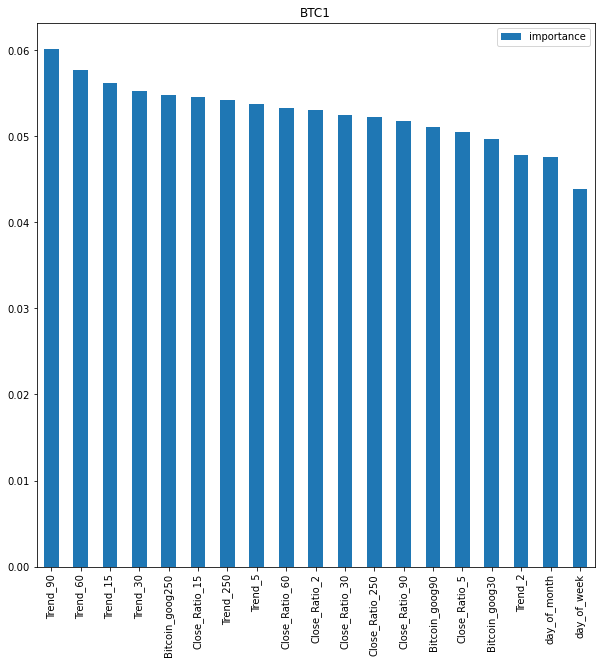

,BTC-USD,ETH-USD,BCH-USD,ZRX-USD,XRP-USD,stoch_k,Tomorrow,After_tomorrow,y1,y2,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_15,Trend_15,Close_Ratio_30,Trend_30,Close_Ratio_60,Trend_60,Close_Ratio_90,Trend_90,Close_Ratio_250,Trend_250,day_of_month,day_of_week,month,Bitcoin_goog30,Bitcoin_goog90,Bitcoin_goog250
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-09-17,457.3340,NaN,NaN,NaN,NaN,NaN,424.4400,394.7960,0,0,1.0000,NaN,1.0000,NaN,1.0000,NaN,1.0000,NaN,1.0000,NaN,1.0000,NaN,1.0000,NaN,17,2,9,0.0667,0.0667,0.0904
2014-09-18,424.4400,NaN,NaN,NaN,NaN,NaN,394.7960,408.9040,0,0,0.9627,424.4400,0.9627,424.4400,0.9627,424.4400,0.9627,424.4400,0.9627,424.4400,0.9627,424.4400,0.9627,424.4400,18,3,9,0.0667,0.0667,0.0900
2014-09-19,394.7960,NaN,NaN,NaN,NaN,NaN,408.9040,398.8210,1,1,0.9638,409.6180,0.9278,409.6180,0.9278,409.6180,0.9278,409.6180,0.9278,409.6180,0.9278,409.6180,0.9278,409.6180,19,4,9,0.0667,0.0667,0.0896
2014-09-20,408.9040,NaN,NaN,NaN,NaN,NaN,398.8210,402.1520,0,0,1.0176,401.8500,0.9704,409.3800,0.9704,409.3800,0.9704,409.3800,0.9704,409.3800,0.9704,409.3800,0.9704,409.3800,20,5,9,0.0667,0.0667,0.0892
2014-09-21,398.8210,NaN,NaN,NaN,NaN,NaN,402.1520,435.7910,1,1,0.9875,403.8625,0.9567,406.7402,0.9567,406.7402,0.9567,406.7402,0.9567,406.7402,0.9567,406.7402,0.9567,406.7402,21,6,9,0.0667,0.0667,0.0888
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-05,20160.7168,1352.8372,122.2188,0.2689,0.4897,0.9468,19955.4434,19546.8496,0,0,0.9957,20248.7803,1.0236,19695.4688,1.0419,19349.3215,1.0201,19763.0879,0.9693,20799.2434,0.9484,21258.6215,0.6660,30272.0832,5,2,10,0.8722,0.9911,1.1689
2022-10-06,19955.4434,1351.7095,118.4388,0.2657,0.4932,0.8321,19546.8496,19416.5684,0,0,0.9949,20058.0801,1.0066,19824.1383,1.0263,19443.1910,1.0078,19800.3471,0.9619,20745.5692,0.9396,21238.8918,0.6608,30199.3523,6,3,10,0.8667,0.9856,1.1659
2022-10-07,19546.8496,1332.5170,116.7987,0.2655,0.5183,0.6040,19416.5684,19505.8809,0,0,0.9897,19751.1465,0.9810,19924.6867,1.0049,19452.0776,0.9868,19808.8979,0.9455,20674.5253,0.9213,21216.1656,0.6488,30125.8693,7,4,10,0.8611,0.9800,1.1628


In [17]:
precision_list, new_predictors = generate_all_models(df_org, tickers, horizons=[2,5,15,30,60,90,250], remove=['month','stoch_k'])

In [ ]:
df_precision = pd.DataFrame(dict(precision_list), index=['precision']).T
# red color for negative values
df_precision.query('precision > 0.5').sort_values(by='precision',ascending=False).plot(kind='bar', figsize=(10,5), title = 'Good Precision', color='green')
try:
    df_precision.query('precision <= 0.5').sort_values(by='precision',ascending=False).plot(kind='bar', figsize=(10,5), title='Bad Precision',color='red')
except:
    pass


df_precision.to_csv('precision_no_month_stochk_15_90.csv')

Kollar TimeSeriesSplit Cross Validation  
Jag gillar min egen backtest-variant bätte   
- Den har start vilket garanterar att första Train-datat inte är för litet  
- Den har step-size i stället för n_splits vilka ger samma index-värden om så önskas  
- Båda har gap 

In [ ]:
horizons=[2,5,15,30,60,90,250]
df, new_predictors = new_features(df_org, tickers[0], 'y1', horizons=horizons)
df, new_predictors = add_google_trends(df, df_trend, tickers[0], new_predictors)

from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=10,gap=1)
for train_index, test_index in tscv.split(df):
    print("TRAIN:", train_index[0], '-', train_index[-1], "\nTEST:", test_index[0], '-', test_index[-1])
    # X_train, X_test = df.iloc[train_index], df.iloc[test_index]
    # y_train, y_test = df.iloc[train_index], df.iloc[test_index]


### Test plotly

In [ ]:
df.columns

In [ ]:
df[['BTC-USD', 'ETH-USD', 'BCH-USD', 'ZRX-USD', 'XRP-USD','Tomorrow','After_tomorrow', 'Trend_2', 'Trend_5', 'Close_Ratio_2']]

In [ ]:
# compute relative development
def rel_dev(df_ticker_):
    df_ticker = df_ticker_.copy()
    df_ticker = df_ticker/df_ticker.shift(1)-1
    df_ticker = df_ticker.dropna()
    just = df_ticker.head(1).values[0]
    df_ticker -= just
    return df_ticker

BTC = df[['BTC-USD']].query('index >= "2022-01-01"'); ETH = df[['ETH-USD']].query('index >= "2022-01-01"'); BCH = df[['BCH-USD']].query('index >= "2022-01-01"'); ZRX = df[['ZRX-USD']].query('index >= "2022-01-01"'); XRP = df[['XRP-USD']].query('index >= "2022-01-01"')

BTC = rel_dev(BTC)
ETH = rel_dev(ETH)
BCH = rel_dev(BCH)
ZRX = rel_dev(ZRX)
XRP = rel_dev(XRP)
# share x-axis

comb = pd.concat([BTC,ETH,BCH,ZRX,XRP],axis=1,)
# plot comb
comb.plot(figsize=(10,5), title='Relative Development of crypto', color=['red','green','blue','orange','purple'])
# share the same x-axis
plt.show()
display(comb)

In [ ]:
import plotly.express as px

# make aa plotly line chart with two lines

fig = px.line(comb, x=comb.index, y=[
              'BTC-USD', 'ETH-USD', 'BCH-USD', 'ZRX-USD', 'XRP-USD'], title='Price')
# make fig higher and more narrow
fig.update_layout(height=800, width=1000)
# thicker lines
fig.update_traces(line=dict(width=2))

fig.show()